### Model 1: Sentiment Analysis : BERT

In [4]:
#install required libraries
!pip install -U tensorflow --no-cache-dir
!pip install -U keras --no-cache-dir
!pip install -U transformers --no-cache-dir
!pip install tf_keras


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

#### Using all feature inputs using BA_Airline_Reviews_Preprocessed.csv

In [7]:
# Load dataset
df = pd.read_csv("BA_Airline_Reviews_Preprocessed.csv")

# Drop missing values in essential columns
df = df.dropna(subset=["ReviewBody", "Recommended"])
df["Recommended"] = df["Recommended"].astype(int)

# Identify numerical and categorical features
numerical_cols = ["OverallRating", "SeatComfort", "CabinStaffService", "GroundService",
                  "ValueForMoney", "Food&Beverages", "InflightEntertainment"]

# Check class distribution and compute class weights
class_counts = df["Recommended"].value_counts()
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(df["Recommended"]), y=df["Recommended"])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Distribution:", class_counts)

# Train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    df["ReviewBody"], df[numerical_cols], df["Recommended"], test_size=0.2, stratify=df["Recommended"], random_state=42)

# Load Hugging Face BERT tokenizer and model
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = TFBertModel.from_pretrained(MODEL_NAME)

# Print vocabulary size
print(f"Vocabulary Size: {tokenizer.vocab_size}")

# Extract and print word embeddings
word_embeddings = bert_model.get_input_embeddings()
print(f"Word Embeddings Shape: {word_embeddings.weight.shape}")

# Tokenize text input
def tokenize_text(text_series, tokenizer, max_length=128):
    tokens = tokenizer(
        text_series.tolist(),
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )
    total_tokens = sum(len(t) for t in tokens["input_ids"].numpy())
    print(f"Total number of tokens in dataset: {total_tokens}")
    return tokens

X_train_tokens = tokenize_text(X_train_text, tokenizer)
X_test_tokens = tokenize_text(X_test_text, tokenizer)

# Build the multi-input model
def build_model():
    # Text Input (BERT)
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

    bert_output = tf.keras.layers.Lambda(
        lambda x: bert_model(x[0], attention_mask=tf.cast(x[1], dtype=tf.int32)).pooler_output,
        output_shape=(768,)
    )([input_ids, attention_mask])

    # Numerical Input
    num_input = tf.keras.layers.Input(shape=(X_train_num.shape[1],), dtype=tf.float32, name="num_input")
    num_dense = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(num_input)

    # Concatenate BERT output with structured data
    combined = tf.keras.layers.Concatenate()([bert_output, num_dense])
    combined = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    combined = tf.keras.layers.Dropout(0.3)(combined)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)  # Binary classification

    return tf.keras.Model(inputs=[input_ids, attention_mask, num_input], outputs=output)

model = build_model()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-5)

# Train the model
history = model.fit(
    [X_train_tokens["input_ids"], X_train_tokens["attention_mask"], X_train_num],
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=([X_test_tokens["input_ids"], X_test_tokens["attention_mask"], X_test_num], y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
y_pred = model.predict([X_test_tokens["input_ids"], X_test_tokens["attention_mask"], X_test_num])
y_pred_labels = np.round(y_pred)


Class Distribution: Recommended
0    2203
1    1498
Name: count, dtype: int64


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Vocabulary Size: 30522
Word Embeddings Shape: (30522, 768)
Total number of tokens in dataset: 378880
Total number of tokens in dataset: 94848
The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'tf_bert_model/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32>
  <tf.Variable 'tf_bert_model/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32>
  <tf.Variable 'tf_bert_model/bert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32>
  <tf.Variable 'tf_bert_model/bert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model/bert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/query/bias:0' shape=(768,) dtype=float32>
  <tf.V

Epoch 1/20
185/185 [==============================] - 435s 2s/step - loss: 2.7434 - accuracy: 0.7507 - val_loss: 2.5037 - val_accuracy: 0.9109 - lr: 3.0000e-05
Epoch 2/20
185/185 [==============================] - 386s 2s/step - loss: 2.3476 - accuracy: 0.8997 - val_loss: 2.1998 - val_accuracy: 0.9379 - lr: 3.0000e-05
Epoch 3/20
185/185 [==============================] - 391s 2s/step - loss: 2.0900 - accuracy: 0.9216 - val_loss: 1.9792 - val_accuracy: 0.9379 - lr: 3.0000e-05
Epoch 4/20
185/185 [==============================] - 1920s 10s/step - loss: 1.8781 - accuracy: 0.9294 - val_loss: 1.7943 - val_accuracy: 0.9366 - lr: 3.0000e-05
Epoch 5/20
185/185 [==============================] - 344s 2s/step - loss: 1.7044 - accuracy: 0.9301 - val_loss: 1.6315 - val_accuracy: 0.9393 - lr: 3.0000e-05
Epoch 6/20
185/185 [==============================] - 397s 2s/step - loss: 1.5570 - accuracy: 0.9358 - val_loss: 1.4937 - val_accuracy: 0.9420 - lr: 3.0000e-05
Epoch 7/20
185/185 [==================

In [8]:
#print classification report
report_dict = classification_report(y_test, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

#round values for readability
report_df = report_df.round(3)

#display in table format
print("\n📊 Classification Report:")
display(report_df)


📊 Classification Report:


,precision,recall,f1-score,support
0,0.959,0.943,0.951,441.000
1,0.919,0.940,0.929,300.000
accuracy,0.942,0.942,0.942,0.942
macro avg,0.939,0.942,0.940,741.000
weighted avg,0.942,0.942,0.942,741.000


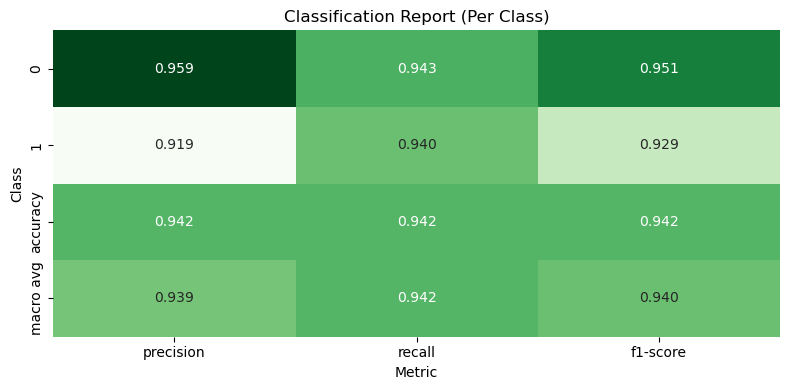

In [9]:
#plot as a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Greens", fmt=".3f", cbar=False)
plt.title("Classification Report (Per Class)")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

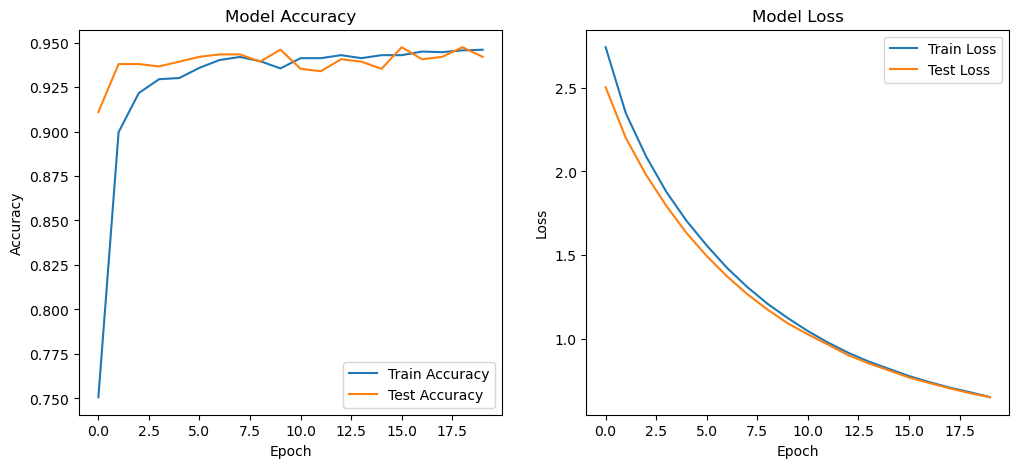

In [10]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_training_history(history)

In [11]:
# Save negative reviews
negative_reviews = df[df["Recommended"] == 0]
negative_reviews.to_csv("BA_Airline_NegativeReviews.csv", index=False)

print("Negative reviews saved to BA_Airline_NegativeReviews.csv")

Negative reviews saved to BA_Airline_NegativeReviews.csv


In [12]:
# Insights about tokenized text
total_tokens = sum(len(tokens) for tokens in X_train_tokens["input_ids"].numpy())
vocab_size = tokenizer.vocab_size
embedding_shape = bert_model.get_input_embeddings().weight.shape

print(f"Total Tokens in Training Data: {total_tokens}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Word Embeddings Shape: {embedding_shape}")

# Additional insights
max_review_length = max(len(tokenizer.tokenize(text)) for text in df["ReviewBody"])
avg_review_length = np.mean([len(tokenizer.tokenize(text)) for text in df["ReviewBody"]])

print(f"Max Review Length (tokens): {max_review_length}")
print(f"Average Review Length (tokens): {avg_review_length:.2f}")

# Check class distribution again
print("Class Distribution in Training Data:\n", y_train.value_counts())
print("Class Distribution in Test Data:\n", y_test.value_counts())

Total Tokens in Training Data: 378880
Vocabulary Size: 30522
Word Embeddings Shape: (30522, 768)
Max Review Length (tokens): 390
Average Review Length (tokens): 90.42
Class Distribution in Training Data:
 Recommended
0    1762
1    1198
Name: count, dtype: int64
Class Distribution in Test Data:
 Recommended
0    441
1    300
Name: count, dtype: int64


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 num_input (InputLayer)      [(None, 7)]                  0         []                            
                                                                                                  
 lambda (Lambda)             (None, 768)                  0         ['input_ids[0][0]',       